## Introduction
This notebook imports sales data for 10 different stores and 50 particular items.  There is a 'units sold' amount for the item for every day of the year.  The point is to compare different modeling / predictive methods to predict the number of units sold given a particular set of input features.  We are comparing the classic linear regression model with the K Nearest Neighbor model. 

Import the necessary libraries and methods.

In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
%matplotlib inline
pd.options.display.float_format = '{:.5f}'.format
from sklearn.model_selection import cross_val_score
from sklearn import neighbors

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

## Import the raw data and clean

In [2]:
df_train = pd.read_csv('train.csv')
df_train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
df_train.tail()

,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


Convert the date column to a datetime datatype for extracting the month and year later.

In [4]:
df_train['date_time'] = pd.to_datetime(df_train['date'])
df_train.head()

,date,store,item,sales,date_time
0,2013-01-01,1,1,13,2013-01-01
1,2013-01-02,1,1,11,2013-01-02
2,2013-01-03,1,1,14,2013-01-03
3,2013-01-04,1,1,13,2013-01-04
4,2013-01-05,1,1,10,2013-01-05


In [5]:
df_train.dtypes

date                 object
store                 int64
item                  int64
sales                 int64
date_time    datetime64[ns]
dtype: object

Extract the month and year and add this new column to the dataframe.

In [6]:
df_train['month'] = df_train.date_time.dt.month
df_train['year'] = df_train.date_time.dt.year
df_train['weekday'] = df_train.date_time.dt.weekday
df_train['day'] = df_train.date_time.dt.day

In [7]:
df_train.head()

,date,store,item,sales,date_time,month,year,weekday,day
0,2013-01-01,1,1,13,2013-01-01,1,2013,1,1
1,2013-01-02,1,1,11,2013-01-02,1,2013,2,2
2,2013-01-03,1,1,14,2013-01-03,1,2013,3,3
3,2013-01-04,1,1,13,2013-01-04,1,2013,4,4
4,2013-01-05,1,1,10,2013-01-05,1,2013,5,5


In [8]:
df_train.tail()

,date,store,item,sales,date_time,month,year,weekday,day
912995,2017-12-27,10,50,63,2017-12-27,12,2017,2,27
912996,2017-12-28,10,50,59,2017-12-28,12,2017,3,28
912997,2017-12-29,10,50,74,2017-12-29,12,2017,4,29
912998,2017-12-30,10,50,62,2017-12-30,12,2017,5,30
912999,2017-12-31,10,50,82,2017-12-31,12,2017,6,31


## Data Exploration
First, lets make a scatterplot by date and sales.

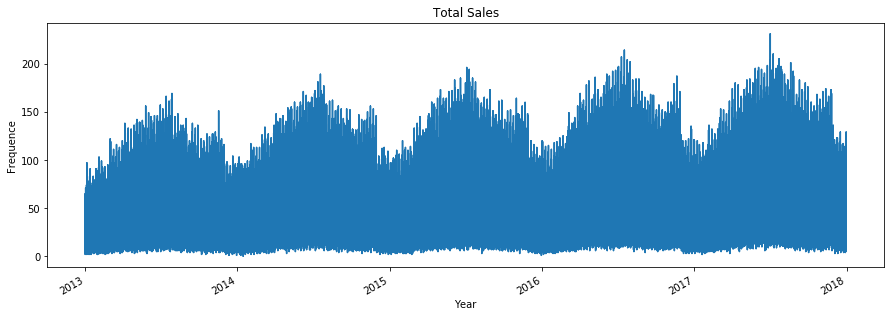

In [9]:
# set the index of this data to equal the date_time column for graphing purposes
df_date_index = df_train.set_index('date_time')

# plot the data
df_date_index['sales'].plot(figsize=(15, 5))
plt.title('Total Sales')
plt.xlabel('Year')
plt.ylabel('Frequence')
plt.show()

The above plot shows total sales for all items in all stores starting on Jan 1, 2013 and ending on Dec 31, 2017.

As you can see there is sesonality in the data.

Here is a histogram of the data.

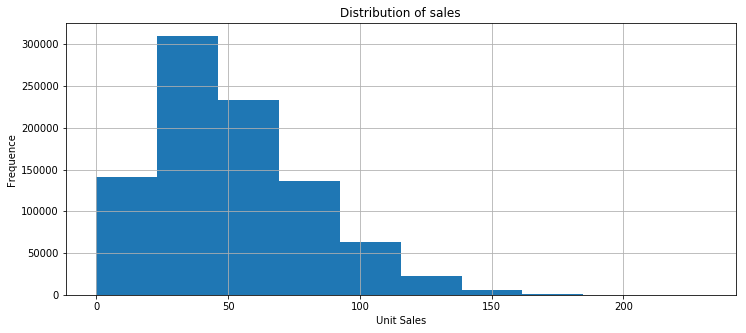

In [22]:
# plot all of the data by unit sales
df_train.hist(column='sales', figsize=(12,5))
plt.title('Distribution of sales')
plt.xlabel('Unit Sales')
plt.ylabel('Frequence')
plt.show()

The above histogram represents the distribution of the sales data.  Most of the unit sales per item are in the 30 - 75 units range.

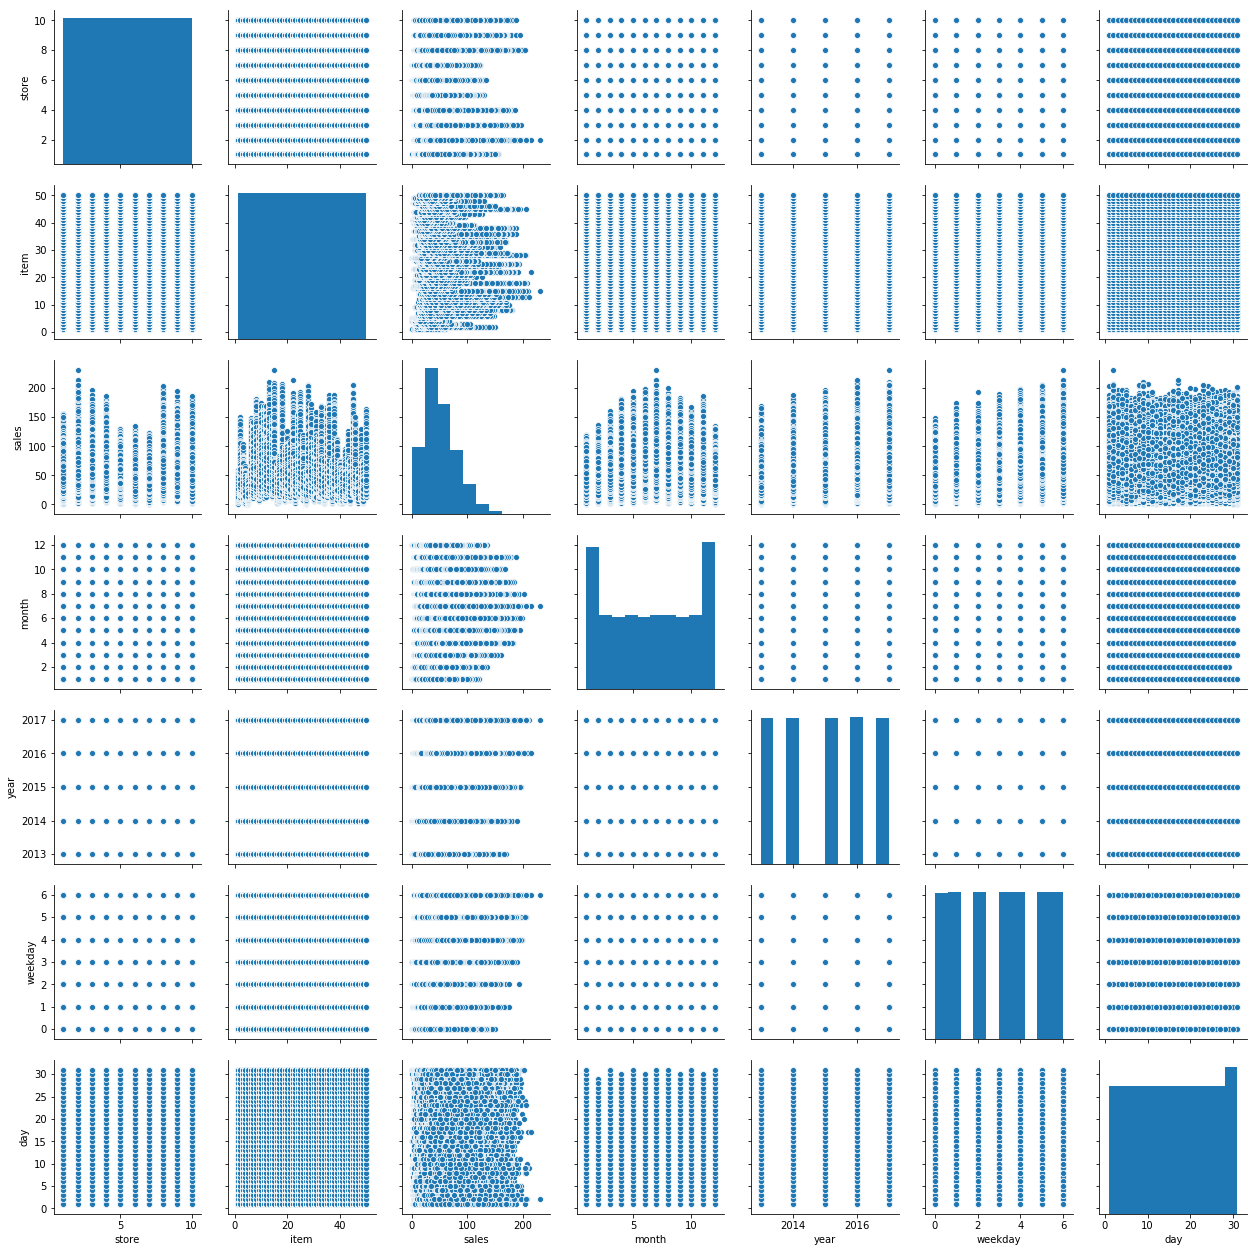

In [11]:
sns.pairplot(df_train)
plt.show()

As you can see in the above pairplot, the features weekday, year, month, item and store all have an effect on sales.  The day of the month doesn't seem to have a signnificant effect.

## Building the model - Using Linear Regression
First, we build the linear regression model using the **store** and **item** as the dependent variables in order to predict sales (independent variable).  

We then test some specific stores and items to see what sales number the model will predict.  

We've also calculated the r-squared value and the cross_val_score to measure the amount of variance that is explained in our model.

In [12]:
from datetime import datetime
start_time = datetime.now()

# Instantiate our model.
regr = linear_model.LinearRegression()

# Fit our model to our data.
x = df_train[['store', 'item']]
y = df_train['sales'].values

regr.fit(x, y)

# Display the attributes we calculated.
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(x, y))

# run some test predictions
y_ = regr.predict([[1, 1]])
y2_ = regr.predict([[2, 1]])
y3_ = regr.predict([[5, 45]])

print(y_)
print(y2_)
print(y3_)

score = cross_val_score(regr, x, y, cv=5)
print("mean cross_val_score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Coefficients: 
 [-0.08192638 -0.11176095]
Intercept: 
 55.550786314088285

R-squared:
0.003202539200479082
[55.35709898]
[55.2751726]
[50.11191162]
mean cross_val_score: -0.18 (+/- 0.37)
Duration: 0:00:00.927053


Now with some seasonality by using **month** as a feature as well as the **store** and **item** that we used previously.

In [13]:
from datetime import datetime
start_time = datetime.now()

# Instantiate our model.
regr = linear_model.LinearRegression()

# Fit our model to our data.
x = df_train[['store', 'item', 'month']]
y = df_train['sales'].values

regr.fit(x, y)

# Display the attributes we calculated.
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(x, y))

# run some test predictions
y_ = regr.predict([[1, 1, 1]])
y2_ = regr.predict([[2, 1, 6]])
y3_ = regr.predict([[5, 45, 11]])

print(y_)
print(y2_)
print(y3_)

score = cross_val_score(regr, x, y, cv=5)
print("mean cross_val_score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Coefficients: 
 [-0.08192638 -0.11176095  0.73005728]
Intercept: 
 50.78822206702552

R-squared:
0.010843776562337704
[51.32459201]
[54.89295203]
[53.37997745]
mean cross_val_score: -0.17 (+/- 0.38)
Duration: 0:00:00.944054


## Building the model - Using K Nearest Neighbor
First, we build the knn model using the **store** and **item** as the dependent variables in order to predict sales (independent variable).  

We then test some specific store and items to see what sales number the model will predict.  

We've also calculated the r-squared value and the cross_val_score to measure the amount of variance that is explained in our model.

In [14]:
from datetime import datetime
start_time = datetime.now()

# KNN model
knn = neighbors.KNeighborsRegressor(n_neighbors=15, weights='uniform')

# Fit our model to our data.
x = df_train[['store', 'item']]
y = df_train['sales'].values

knn.fit(x, y)

# T = np.arange(0, 365, 0.1)[:, np.newaxis]

# run some test predictions
y_ = knn.predict([[1, 1]])
y2_ = knn.predict([[2, 1]])
y3_ = knn.predict([[5, 45]])

print(y_)
print(y2_)
print(y3_)

# Display the r-squared
print('\nR-squared:')
print(knn.score(x, y))

from sklearn.model_selection import cross_val_score

score = cross_val_score(knn, x, y, cv=5)
print("mean cross_val_score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

[13.66666667]
[18.33333333]
[58.73333333]

R-squared:
0.45206756997968445
mean cross_val_score: -0.43 (+/- 0.61)
Duration: 0:03:24.438693


Now use the **month** feature for seasonality.

In [15]:
from datetime import datetime
start_time = datetime.now()

# KNN model
knn = neighbors.KNeighborsRegressor(n_neighbors=15, weights='uniform')

# Fit our model to our data.
x = df_train[['store', 'item', 'month']]
y = df_train['sales'].values

knn.fit(x, y)

# run some test predictions
y_ = knn.predict([[1, 1, 1]])
y2_ = knn.predict([[2, 1, 6]])
y3_ = knn.predict([[5, 45, 11]])

print(y_)
print(y2_)
print(y3_)

# Display the r-squared
print('\nR-squared:')
print(knn.score(x, y))

from sklearn.model_selection import cross_val_score

score = cross_val_score(knn, x, y, cv=5)
print("mean cross_val_score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

[10.66666667]
[33.13333333]
[66.73333333]

R-squared:
0.7947900775677502
mean cross_val_score: -0.12 (+/- 0.74)
Duration: 0:01:14.015233


One more time adding the **year** feature since the quantity of sales per item increases as time goes on.

In [16]:
from datetime import datetime
start_time = datetime.now()

# KNN model
knn = neighbors.KNeighborsRegressor(n_neighbors=15, weights='uniform')

# Fit our model to our data.
x = df_train[['store', 'item', 'month', 'year']]
y = df_train['sales'].values

knn.fit(x, y)

# run some test predictions
y_ = knn.predict([[1, 1, 1, 2013]])
y2_ = knn.predict([[2, 1, 6, 2015]])
y3_ = knn.predict([[5, 45, 11, 2017]])

print(y_)
print(y2_)
print(y3_)

# Display the r-squared
print('\nR-squared:')
print(knn.score(x, y))

from sklearn.model_selection import cross_val_score

score = cross_val_score(knn, x, y, cv=5)
print("mean cross_val_score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

[10.4]
[33.4]
[73.46666667]

R-squared:
0.8715750260337896
mean cross_val_score: -0.07 (+/- 0.77)
Duration: 0:01:11.489089


One more time with day of the week ('weekday') and weighting by 'distance'.

In [17]:
from datetime import datetime
start_time = datetime.now()

# KNN model
knn = neighbors.KNeighborsRegressor(n_neighbors=15, weights='distance')

# Fit our model to our data.
x = df_train[['store', 'item', 'month', 'year', 'weekday']]
y = df_train['sales'].values

knn.fit(x, y)

# run some test predictions
y_ = knn.predict([[1, 1, 1, 2013, 0]])
y2_ = knn.predict([[2, 1, 6, 2015, 5]])
y3_ = knn.predict([[5, 45, 11, 2017, 6]])

print(y_)
print(y2_)
print(y3_)

# Display the r-squared
print('\nR-squared:')
print(knn.score(x, y))

from sklearn.model_selection import cross_val_score

score = cross_val_score(knn, x, y, cv=5)
print("mean cross_val_score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

[10.25]
[41.5]
[85.25]

R-squared:


MemoryError: 

## Evaluating the model
Linear Regression Model - Without Seasonality:  
- r-squared:  **.0032**
- cross_val_score:  **-.18 +/- .37**

Linear Regression Model - With Seasonality ('month' feature)
- r-squared:  **.0108**
- cross_val_score:  **-.17 +/- .38**

K Nearest Neighbor Model - Without Seasonality:
- r-squared:  **.452**
- cross_val_score:  **-.43 +/- .61**

K Nearest Neighbor Model - With Seasonality (**'month'** feature):
- r-squared:  **.795**
- cross_val_score:  **-.12 +/- .74**

K Nearest Neighbor Model - With Seasonality (**'month'** feature) and yearly increase (**'year'** feature):
- r-squared:  **.872**
- cross_val_score:  **-.07 +/- .77**

K Nearest Neighbor Model - With Seasonality (**'month'**), yearly increase (**'year'**), day of the week (**'weekday'**) and using **'distance'** for the weighted knn score calculation:
- r-squared:  **.951**
- cross_val_score:  **-.02 +/- .76**

## Discussion and conclusion
The best model was using the 5 features **'store', 'item', 'month', 'year', 'weekday'** and using **'distance'** for the weighted distance between nearest neighbors.  This model yielded an r-squared value of **.951** and cross_val_score of -.02 +/- 0.76.

The 2nd best model for this dataset so far is the KNN model using the 4 features of store, item, month and year (with 'uniform' weighting).  The accuracy of the model using the r-squared value is **.872**; meaning that the model explains about 87% of the variance of the data.

It is a little troubling that the best cross_val_score obtained was -0.02.  More investigation is needed to explain the differences in the two accuracy statistical measures.

Given the seasonality of the data, as expected, the linear regression model was not a good fit and the KNN modeling method was far superior.  However, the KNN models took about 2 to 3 minutes to compute vs just milliseconds for the LR model.

Testing the model using the day of the month decreased the r-squared values and overall accuracy.  It looks like this extra feature added noise to the data, therefore minimizing the effectiveness of the model.

So, in this data, there is a yearly seasonality as well as "seasonality" within any given week.  Both features had an contributing impact on the results.